In [1]:
# Author: Volker Hoffmann, SINTEF <volker.hoffmann@sintef.no> <volker@cheleb.net>
# Update: 09 January 2018

In this notebook, we'll explore using a matched filter to recover a signal embedded within a time series. In particular, we embed a synthetic signature of a charging battery within a time series of power consumption of a single home (the same data as in the previous notebook).

A practical application of this is the detection of certain kinds of appliances within a time series. In this example, the load profile and total energy consumption of the charging battery corresponds to that of a typical electric vehicle.

A matched filter is based on the fact that the correlation (or convolution, for that matter) of a signal with itself is unity. If we expect some signal (let's call it a *template*) to be embedded with another signal, we may simply compute the cross-correlation of the signal with the template. If the template is in fact embedded in the signal, the cross-correlation will peak at the location of the template. The procedure can be applied to signals and template of any dimensionality (for example, one dimensinal time series, two dimensional image data, etc).

In image processing, examples are particularly illustrative. Consider the three panels below. On the left, we have a single coin (this will be our template). In the middle, we have a picture of various coins. To programmatically find the location of every single coin in the middle image, we calculate the cross-correlation of thge template with the image. The result is show in the leftmost panel where, indeed, the cross-correlation peaks at the locations of each coin.

![Illustratioin of Matched Filters](http://scikit-image.org/docs/dev/_images/sphx_glr_plot_template_001.png) 

For more information on matched filtering in image processing, see:

- https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/template.py
- http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_template.html

Again, do note that we can compute the crosss-correlation between signals of arbitrary dimensionality, so that the procedure can be applied to both time series as well as image data (and a wide range of other signals).

Fun Fact: Other uses of matched filtering include, for example, detection of gravitational waves. Here, libraries of gravitational wave signatures (templates) are derived from numerical simulations. These templates are then run against extremely precise measurements of spacetime contractions. See, for example, here:

- https://notebooks.azure.com/losc/libraries/tutorials/html/LOSC_Event_tutorial.ipynb

As before, we now set up our environment. Note that we import `skimage` (Scikit-Image). This module contains the template matching (another name for matched filters) we will be useing.

In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 72
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
import skimage.feature.template

In [4]:
plt.style.use('ggplot')

# Load UkDale

As before, we will be using the publically available UkDale energy consumption dataset and use Pandas to manage the data in memory. Recall that the dataset can be obtained from http://jack-kelly.com/data/ (click on DOIs for the 2017 further down on the page).

In [5]:
# To convert this to the native Pandas data, we define this function.
def dateparse(time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [6]:
# basedir = '/storage2/energy/ukdale'
# basedir = '/Users/volker/Work_Sintef/DatasetsPublic/UkDale'
basedir = '/home/volker/OneDrive_SINTEF/Datasets/UkDale'

# fname = "%s/house_%i_mainsonly/channel_1.dat" % (basedir, 1)
fname = "%s/house_%i/channel_1.dat" % (basedir, 1)

We now load the energy demand measured at the mains connection into the house. Note that the aggregate (mains) power reading comes from a current transformer which only reports apparent power in units of VA. This time around, we will be a bit liberal here and simply assume this is true power in units of W instead.

This has no repercussions as we're using the UkDale set simply to have some sort of energy time-series.

In [7]:
# https://stackoverflow.com/questions/34122395/reading-a-csv-with-a-timestamp-column-with-pandas
df = pd.read_csv(fname, parse_dates=True, date_parser=dateparse, \
                 names=[ 'timestamp', 'power_W' ], index_col='timestamp', header=None, sep=' ')

# Extract Slice, Downsample, Inspect

We now cut out a small piece of the time series and resample it to 10 minute intervals.

In [8]:
# Extract Slice & Downsample
df = df[(df.index >= '2017-04-05 19:00:00') & (df.index < '2017-04-08 19:00:00')]
df_10min = df.resample('10T').mean()

Let's have a look.

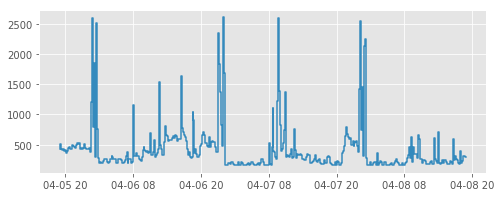

In [9]:
# setup plot
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,3)

# loop through the list of dataframes above
ax.step(df_10min.index, df_10min.power_W, color='#348ABD')

# this suppresses some junk output
pass

# Prepare Battery Data

To first order, charge signature of modern electric vehicles follow roughly trapezoidal shapes [1], so we can model our charging electric vehicle as such. The following function implements such a load profile. After defining the function, we load the profile, 

[1] At higher level of detail, parts of the load profile look more like exponentials, but these appear linear when looking at time intervals larger than a few minutes.

In [10]:
# Simple Battery
# Cf. Zhang+ 2011 ("An Improved Non-Intrusive Load Monitoring Method for Recognition of Electric Vehicle Battery Charging Load")
#     DOI 10.1016/j.egypro.2011.10.015
def simple_battery():
    """time in seconds. power in watt."""
    time = np.arange(25000, dtype=np.float)
    power = np.zeros_like(time)
    power[:1500] = time[:1500] * (3400.0/1500.0)
    power[1500:20000] = 3400.0
    power[20000:] = ((time[20000:]-20000.0) * (3400.0/5000.0))[::-1]
    # sampled every 10 minutes
    time = time[::60*10]
    power = power[::60*10]
    return time, power

In [11]:
tbat, pbat = simple_battery()

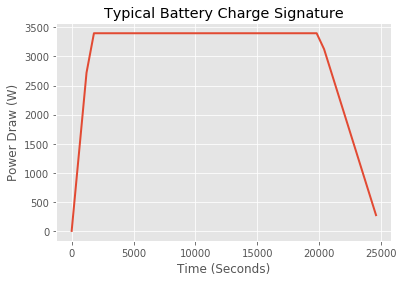

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(tbat,pbat,color='#E24A33',linewidth=2)
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Power Draw (W)')
ax.set_title('Typical Battery Charge Signature')
pass

# Plot Consumption Data w/ Battery

We now add the battery signature to our data frame as a separate column. Afterwards, we add the the battery profile to the measured consumption profile. We then show an excerp of the data frame at the point the synthetic battery kicks in charging. Finally, we plot everything.

In [13]:
# add the battery signature to our data frame
df_10min['battery_W'] = np.zeros_like(df_10min.power_W)
df_10min.loc[80:80+len(pbat), 'battery_W'] = pbat

# compute total power consumption
df_10min['power_total_W'] = df_10min['power_W'] + df_10min['battery_W']

# show 
df_10min.head(84).tail(6)

,power_W,battery_W,power_total_W
timestamp,,,
2017-04-06 08:00:00,214.687500,0.0,214.687500
2017-04-06 08:10:00,1158.965909,0.0,1158.965909
2017-04-06 08:20:00,312.947917,0.0,312.947917
2017-04-06 08:30:00,310.223404,1360.0,1670.223404
2017-04-06 08:40:00,357.082474,2720.0,3077.082474
2017-04-06 08:50:00,311.391753,3400.0,3711.391753


The following figure summarizes our current state. We have the synthetic battery (top panel), the measured consumption profile from the house (middle panel), and the consumption profile with the battery embedded (bottom panel).

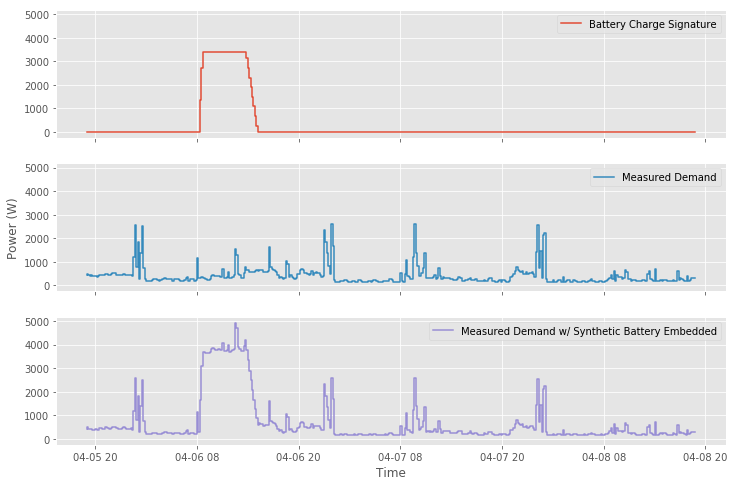

In [14]:
# Plot
fig, axarr = plt.subplots(3,1,sharex=True,sharey=True)
fig.set_size_inches(12,8)

axarr[0].step(df_10min.index, df_10min.battery_W, \
              label='Battery Charge Signature', color='#E24A33')
axarr[1].step(df_10min.index, df_10min.power_W, \
              label='Measured Demand', color='#348ABD')
axarr[2].step(df_10min.index, df_10min.power_total_W, \
              label='Measured Demand w/ Synthetic Battery Embedded', color='#988ED5')

for ax in axarr:
    ax.legend()

axarr[2].set_xlabel('Time')
axarr[1].set_ylabel('Power (W)')

pass

# Match w/ 10 Minute Data

Calculate XCorr.

In [15]:
xcorr_10min = \
    skimage.feature.template.match_template(np.asarray(df_10min.power_total_W)[:,np.newaxis], \
                                            pbat[:,np.newaxis], \
                                            pad_input=True)

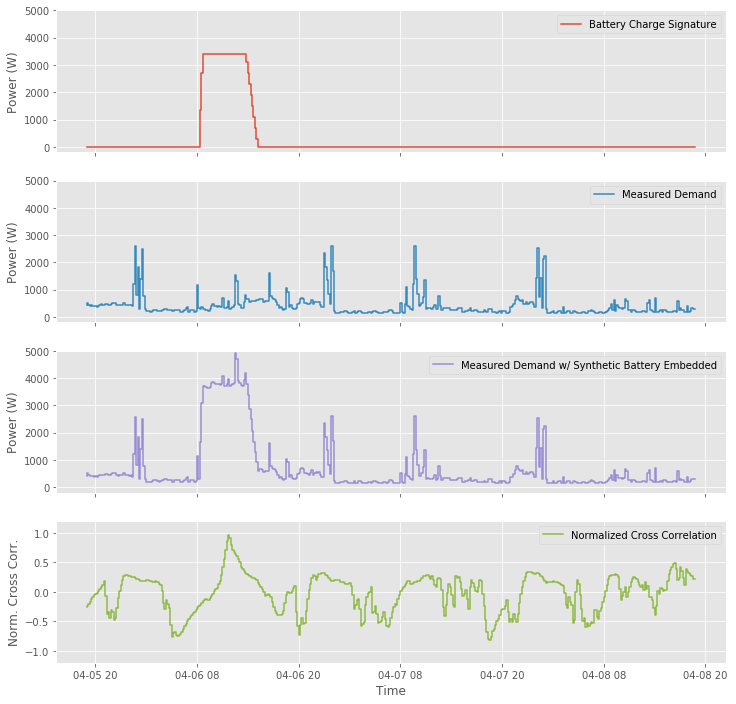

In [16]:
# Plot
fig, axarr = plt.subplots(4,1,sharex=True)
fig.set_size_inches(12,12)

axarr[0].step(df_10min.index, df_10min.battery_W, \
              label='Battery Charge Signature', color='#E24A33')
axarr[1].step(df_10min.index, df_10min.power_W, \
              label='Measured Demand', color='#348ABD')
axarr[2].step(df_10min.index, df_10min.power_total_W, \
              label='Measured Demand w/ Synthetic Battery Embedded', color='#988ED5')
axarr[3].step(df_10min.index, xcorr_10min, \
              label='Normalized Cross Correlation', color='#8EBA42')

# Add Legend
for ax in axarr:
    ax.legend()

# Axis Limits, Labels
for ax in axarr[:3]:
    ax.set_ylim([-200,5000])
    ax.set_ylabel('Power (W)')
axarr[-1].set_ylim([-1.2,1.2])    
axarr[-1].set_xlabel('Time')
axarr[-1].set_ylabel('Norm. Cross Corr.')

pass

# Match w/ 10, 60, 120 Minute Data

In [17]:
df_60min = df_10min.resample('60T').mean()
df_60min = df_60min.resample('10T').pad()

df_120min = df_10min.resample('120T').mean()
df_120min = df_120min.resample('10T').pad()

In [18]:
xcorr_60min = \
    skimage.feature.template.match_template(np.asarray(df_60min.power_total_W)[:,np.newaxis], \
                                            pbat[:,np.newaxis], \
                                            pad_input=True)

xcorr_120min = \
    skimage.feature.template.match_template(np.asarray(df_120min.power_total_W)[:,np.newaxis], \
                                            pbat[:,np.newaxis], \
                                            pad_input=True)

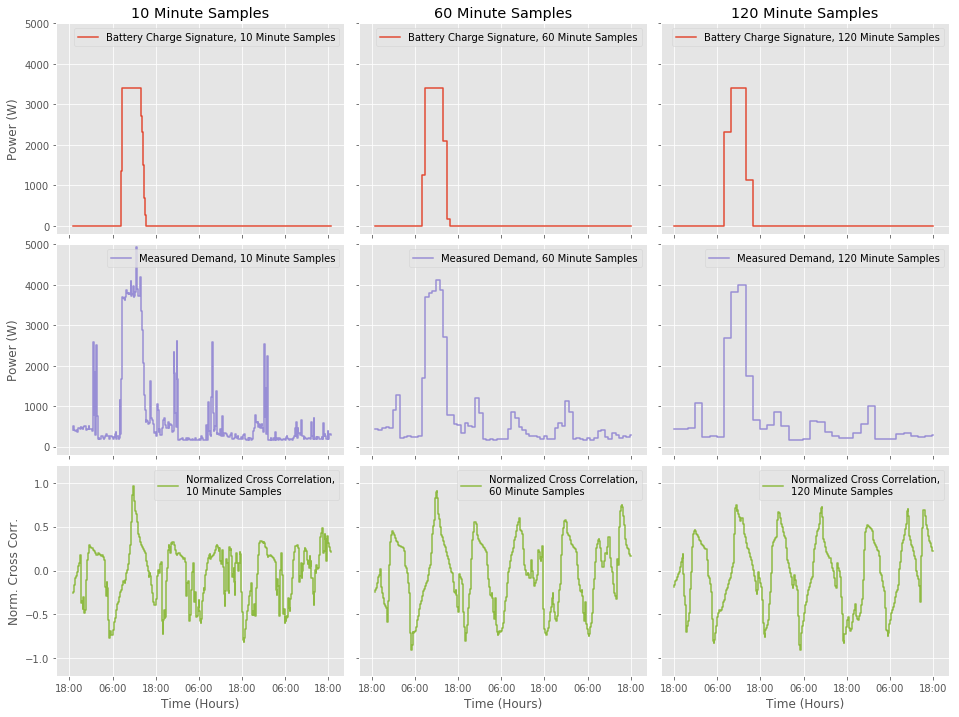

In [19]:
# Setup Figure
fig, axarr = plt.subplots(3,3,sharex=True)
fig.set_size_inches(16,12)

# ############# #
# PLOTTING CODE #
# ############# #

# Left Column
axarr[0,0].step(df_10min.index, df_10min.battery_W, \
                color='#E24A33', \
                label='Battery Charge Signature, 10 Minute Samples')
axarr[1,0].step(df_10min.index, df_10min.power_total_W, \
                color='#988ED5', \
                label='Measured Demand, 10 Minute Samples')
axarr[2,0].step(df_10min.index, xcorr_10min, \
                color='#8EBA42', \
                label='Normalized Cross Correlation,\n10 Minute Samples')

# Middle Column
axarr[0,1].step(df_60min.index, df_60min.battery_W, \
                color='#E24A33', \
                label='Battery Charge Signature, 60 Minute Samples')
axarr[1,1].step(df_60min.index, df_60min.power_total_W, \
                color='#988ED5', \
                label='Measured Demand, 60 Minute Samples')
axarr[2,1].step(df_60min.index, xcorr_60min, \
                color='#8EBA42', \
                label='Normalized Cross Correlation,\n60 Minute Samples')

# Right Column
axarr[0,2].step(df_120min.index, df_120min.battery_W, \
                color='#E24A33', \
                label='Battery Charge Signature, 120 Minute Samples')
axarr[1,2].step(df_120min.index, df_120min.power_total_W, \
                color='#988ED5', \
                label='Measured Demand, 120 Minute Samples')
axarr[2,2].step(df_120min.index, xcorr_120min, \
                color='#8EBA42', \
                label='Normalized Cross Correlation,\n120 Minute Samples')

# ############ #
# STYLING CODE #
# ############ #

# Titles
axarr[0,0].set_title('10 Minute Samples')
axarr[0,1].set_title('60 Minute Samples')
axarr[0,2].set_title('120 Minute Samples')

# Legends
for ax in axarr.flatten():
    ax.legend(loc='best')

# Limits, Consumption
for icol in [ 0, 1, 2 ]:
    for irow in [ 0, 1 ]:
        axarr[irow,icol].set_ylim([-200,5000])
        
# Remove Some Axis Labels
for icol in [ 1, 2 ]:
    for irow in [ 0, 1, 2 ]:
        plt.setp(axarr[irow,icol].get_yticklabels(), visible=False)

# Limits, Cross Correlation
for icol in [ 0, 1, 2 ]:
    axarr[2,icol].set_ylim([-1.2,1.2])
    
# Format Date/Time String, Set Axis Label
for icol in [ 0, 1, 2 ]:
    axarr[2,icol].xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    axarr[2,icol].set_xlabel('Time (Hours)')
    
# Set Y-Axis Label
axarr[0,0].set_ylabel('Power (W)')
axarr[1,0].set_ylabel('Power (W)')
axarr[2,0].set_ylabel('Norm. Cross Corr.')
    
# Tighten
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Where to go from here?

- Library of charge signature?
- Fractional charges?
- Confusion with similar high load appliances?